In [19]:
import pandas as pd

df = pd.read_csv('../../survey_processing/processed_data/dhs_processed.csv')
df

,CENTROID_ID,SURVEY_NAME,COUNTRY,YEAR,LATNUM,LONGNUM,cluster,health_vac_moddep,health_con_moddep,health_ari_moddep,...,hv201_71,hv009,hv105,hv216,v005,hv205_14,v312_17,v312_2,hv201_12,hv205_31
0,UG201600000001,Uganda_DHS_2016,Uganda,2016,0.320188,32.568206,1.0,0.000000,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.000000
1,UG201600000002,Uganda_DHS_2016,Uganda,2016,0.340653,32.593627,2.0,0.032258,0.0,0.0,...,0.0,0.148859,0.299020,0.065217,0.119688,0.0,0.0,0.0,0.0,0.166667
2,UG201600000003,Uganda_DHS_2016,Uganda,2016,0.313103,32.566556,3.0,0.052632,0.0,0.0,...,0.0,0.116183,0.058824,0.065217,0.085795,0.0,0.0,0.0,0.0,0.000000
3,UG201600000004,Uganda_DHS_2016,Uganda,2016,0.353368,32.558144,4.0,0.108108,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.000000
4,UG201600000005,Uganda_DHS_2016,Uganda,2016,0.367388,32.594357,5.0,0.034483,0.0,0.0,...,0.0,0.148133,0.435294,0.065217,0.146261,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24209,ET201900000301,Ethiopia_DHS_2019,Ethiopia,2019,9.614227,41.997375,301.0,0.054054,0.0,0.0,...,0.0,0.247087,0.535858,0.068791,0.005866,0.0,0.0,0.0,0.0,0.986301
24210,ET201900000302,Ethiopia_DHS_2019,Ethiopia,2019,9.554591,41.863785,302.0,0.098361,0.0,0.0,...,0.0,0.203657,0.295486,0.078868,0.008044,0.0,0.0,0.0,0.0,0.093023
24211,ET201900000303,Ethiopia_DHS_2019,Ethiopia,2019,9.524405,41.834015,303.0,0.042553,0.0,0.0,...,0.0,0.249230,0.496521,0.078541,0.009587,0.0,0.0,0.0,0.0,0.946237
24212,ET201900000304,Ethiopia_DHS_2019,Ethiopia,2019,9.514266,41.770584,304.0,0.029126,0.0,0.0,...,0.0,0.272525,0.478391,0.071872,0.005691,0.0,0.0,0.0,0.0,0.540816


In [20]:
import geopandas as gpd
from shapely.geometry import Point
import warnings
warnings.filterwarnings('ignore')
# Convert the DataFrame into a GeoDataFrame
def append_geo(df):
    gdf_points = gpd.GeoDataFrame(
        df, 
        geometry=gpd.points_from_xy(df['LONGNUM'], df['LATNUM']),
        crs="EPSG:4326"
    )

    # Load the admin 2 boundaries GeoDataFrame
    # Ensure that the file includes polygons for admin 2 subdivisions in Africa
    admin2_gdf = gpd.read_file('afr_adm2/afr_g2014_2013_2.shp')

    # Project both GeoDataFrames to a common CRS if necessary
    if admin2_gdf.crs != gdf_points.crs:
        admin2_gdf = admin2_gdf.to_crs(gdf_points.crs)

    # Perform the spatial join
    # 'how="left"' means all points will remain, gaining admin 2 data if they fall within a polygon
    joined_gdf = gpd.sjoin(gdf_points, admin2_gdf, how="left", predicate="within")

    # Suppose the admin 2 name column in the polygons is named "admin2_name"
    return joined_gdf

In [21]:
import pandas as pd
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

def get_train_df(fold):
    folder = f'../dino/results/split_spatialS_{fold}_[4, 3, 2]/'
    # Load training and test data
    X_train = pd.read_csv(folder+'X_train.csv')
    y_train = pd.read_csv(folder+'y_train.csv').squeeze()  # ensure it's a Series
    X_test = pd.read_csv(folder+'X_test.csv')
    y_test = pd.read_csv(folder+'y_test.csv').squeeze()

    # Define a pipeline with scaling and RidgeCV
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('ridge', RidgeCV(alphas=[0.001, 0.01, 0.1, 1.0, 10.0, 100, 1000], cv=5))
    ])

    # Fit the pipeline on training data
    pipeline.fit(X_train, y_train)

    # Predict on the test set
    y_pred = pipeline.predict(X_test).clip(0, 1)
    train_pred = pipeline.predict(X_train).clip(0, 1)

    # Calculate MAE
    mae = mean_absolute_error(y_test, y_pred)
    print("Test MAE:", mae)
    train_mae = mean_absolute_error(y_train, train_pred)
    print("Train MAE:", train_mae)
    test_csv = f'../../survey_processing/processed_data/test_fold_{fold}.csv'
    train_csv = f'../../survey_processing/processed_data/train_fold_{fold}.csv'
    test_df = pd.read_csv(test_csv)
    train_df = pd.read_csv(train_csv)
    import os
    available_imagery = []
    imagery_path = '/home/cs-yang3/rds/rds-t2-cs177-KNoCjrg2atA/wp3/data/satellite_imagery/esa_10'
    for d in os.listdir(imagery_path):
        if d[-2] == 'S':
            for f in os.listdir(os.path.join(imagery_path, d)):
                available_imagery.append(os.path.join(imagery_path, d, f))

    def is_available(centroid_id):
        for centroid in available_imagery:
            if centroid_id in centroid:
                return True
        return False
    test_df = test_df[test_df['CENTROID_ID'].apply(is_available)]
    train_df = train_df[train_df['CENTROID_ID'].apply(is_available)]

    test_df.dropna(subset=['deprived_sev'], inplace=True)
    train_df.dropna(subset=['deprived_sev'], inplace=True)
    test_df['y_pred'] = y_pred
    train_df['y_pred'] = train_pred
    return train_df

# get all 5 fold and stack them
train_df = pd.concat([get_train_df(fold) for fold in range(1, 6)])

Test MAE: 0.1577105866092422
Train MAE: 0.14491674428792378
Test MAE: 0.1630556082997197
Train MAE: 0.14680322166179124
Test MAE: 0.170544348419581
Train MAE: 0.14723291470233427
Test MAE: 0.17071136693345051
Train MAE: 0.13616268490074776
Test MAE: 0.1623569733411248
Train MAE: 0.14193254066179617


In [22]:
train_df['error'] = (train_df['deprived_sev'] - train_df['y_pred']).abs()
train_df['are'] = (train_df['error'] / train_df['deprived_sev'])

In [23]:
train_df = (
    train_df.groupby('CENTROID_ID', as_index=False)  # Group by CENTROID_ID
    .agg(lambda x: x.mean() if x.dtype.kind in 'biufc' else x.iloc[0])  # Mean for numeric, first value for others
)
train_df

,CENTROID_ID,SURVEY_NAME,COUNTRY,YEAR,LATNUM,LONGNUM,cluster,health_vac_moddep,health_con_moddep,health_ari_moddep,...,hv216,v005,hv205_14,v312_17,v312_2,hv201_12,hv205_31,y_pred,error,are
0,AO201500000001,Angola_DHS_2015,Angola,2015.0,-12.101381,14.140703,1.0,0.120000,0.013333,0.0,...,0.116522,0.130570,0.000,0.0,0.0,0.0,1.000000,0.927217,0.072783,0.072783
1,AO201500000002,Angola_DHS_2015,Angola,2015.0,-9.663518,20.377014,2.0,0.087719,0.000000,0.0,...,0.157609,0.025116,0.125,0.0,0.0,0.0,0.000000,0.403826,0.140668,0.534539
2,AO201500000003,Angola_DHS_2015,Angola,2015.0,-8.928897,13.299542,3.0,0.020408,0.000000,0.0,...,0.122020,0.383522,0.000,0.0,0.0,0.0,0.000000,0.333960,0.058450,0.212151
3,AO201500000004,Angola_DHS_2015,Angola,2015.0,-14.287585,17.621653,4.0,0.129630,0.018519,0.0,...,0.173913,0.044353,0.000,0.0,0.0,0.0,0.592593,0.895784,0.104216,0.104216
4,AO201500000005,Angola_DHS_2015,Angola,2015.0,-14.211038,13.546263,5.0,0.109091,0.018182,0.0,...,0.065217,0.013299,0.000,0.0,0.0,0.0,1.000000,0.956312,0.043688,0.043688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8645,ZW201500000396,Zimbabwe_DHS_2015,Zimbabwe,2015.0,-17.915288,31.156115,396.0,0.024390,0.000000,0.0,...,0.065217,NaN,0.000,0.0,0.0,0.0,0.000000,0.305611,0.084633,0.216873
8646,ZW201500000397,Zimbabwe_DHS_2015,Zimbabwe,2015.0,-18.379501,31.872287,397.0,0.025641,0.000000,0.0,...,0.081522,0.133588,0.000,0.0,0.0,0.0,0.250000,0.685878,0.378186,1.229104
8647,ZW201500000398,Zimbabwe_DHS_2015,Zimbabwe,2015.0,-16.660612,29.850649,398.0,0.000000,0.000000,0.0,...,0.148338,0.198206,0.000,0.0,0.0,0.0,0.431373,0.959746,0.245460,0.343644
8648,ZW201500000399,Zimbabwe_DHS_2015,Zimbabwe,2015.0,-17.914251,30.956975,399.0,0.045455,0.022727,0.0,...,NaN,NaN,0.000,0.0,0.0,0.0,0.000000,0.214804,0.032610,0.143485


In [24]:
train_df['error'].mean(), train_df['are'].mean()

(0.1417276047403057, inf)

In [25]:
train_with_geo = append_geo(train_df)

In [26]:
# aggregated by country + admin2 and average by error
grouped_df = train_with_geo.groupby(['COUNTRY', 'ADM2_NAME'])[['deprived_sev','y_pred','error','are','LATNUM','LONGNUM']].mean().reset_index()

In [27]:
grouped_df.head()

,COUNTRY,ADM2_NAME,deprived_sev,y_pred,error,are,LATNUM,LONGNUM
0,Angola,Alto Cauale,0.979592,0.985803,0.010073,0.010283,-7.487095,16.225420
1,Angola,Alto Zambeze,0.928870,0.883279,0.055567,0.064337,-11.772236,23.197412
2,Angola,Ambaca,0.760634,0.756370,0.128623,0.252149,-8.266549,15.527677
3,Angola,Amboim,0.771490,0.731669,0.174676,0.294805,-10.852732,14.415432
4,Angola,Ambriz,0.595293,0.743433,0.148140,0.303216,-7.857252,13.418285


In [28]:
grouped_df['admin2_error'] = (grouped_df['deprived_sev'] - grouped_df['y_pred']).abs()

In [29]:
grouped_df.admin2_error.mean()

0.07847086658395892

<Axes: >

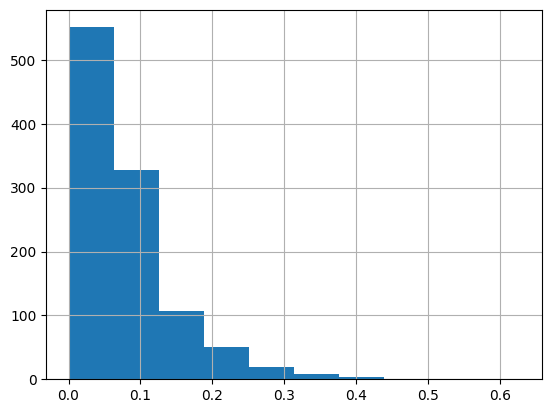

In [30]:
grouped_df.admin2_error.hist()

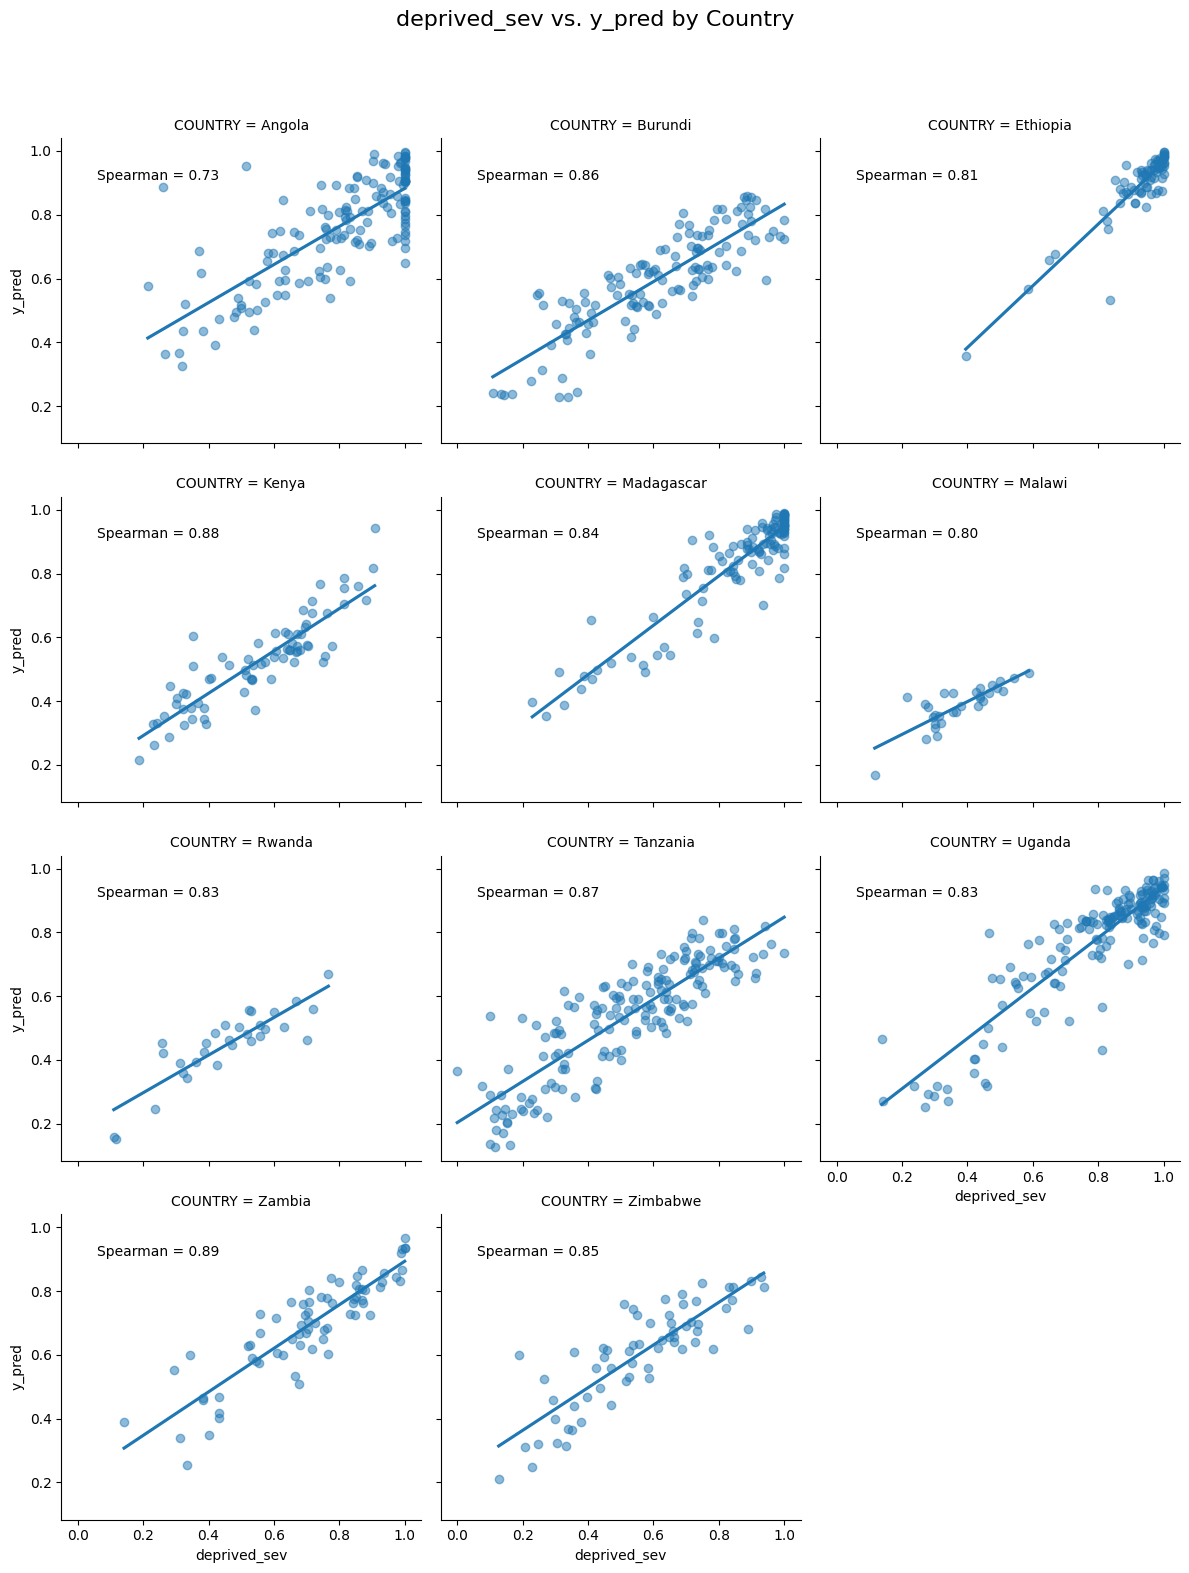

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import spearmanr

# Assume your DataFrame is called df
# df columns: COUNTRY, ADM2_NAME, deprived_sev, y_pred

# Create the facet grid scatter plots with regression lines
g = sns.lmplot(data=grouped_df, x='deprived_sev', y='y_pred', col='COUNTRY', 
               col_wrap=3, height=4, aspect=1, scatter_kws={'alpha':0.5}, ci=None)

# Compute and annotate R² for each subplot
for ax, country in zip(g.axes.flat, grouped_df['COUNTRY'].unique()):
    country_data = grouped_df[grouped_df['COUNTRY'] == country]
    rho, p_value = spearmanr(country_data['deprived_sev'], country_data['y_pred'])
    # Position the text inside the subplot
    ax.text(0.1, 0.9, f'Spearman = {rho:.2f}', transform=ax.transAxes, fontsize=10, verticalalignment='top')

plt.subplots_adjust(top=0.9)
g.fig.suptitle("deprived_sev vs. y_pred by Country", fontsize=16)  # Add a global title if desired
plt.show()

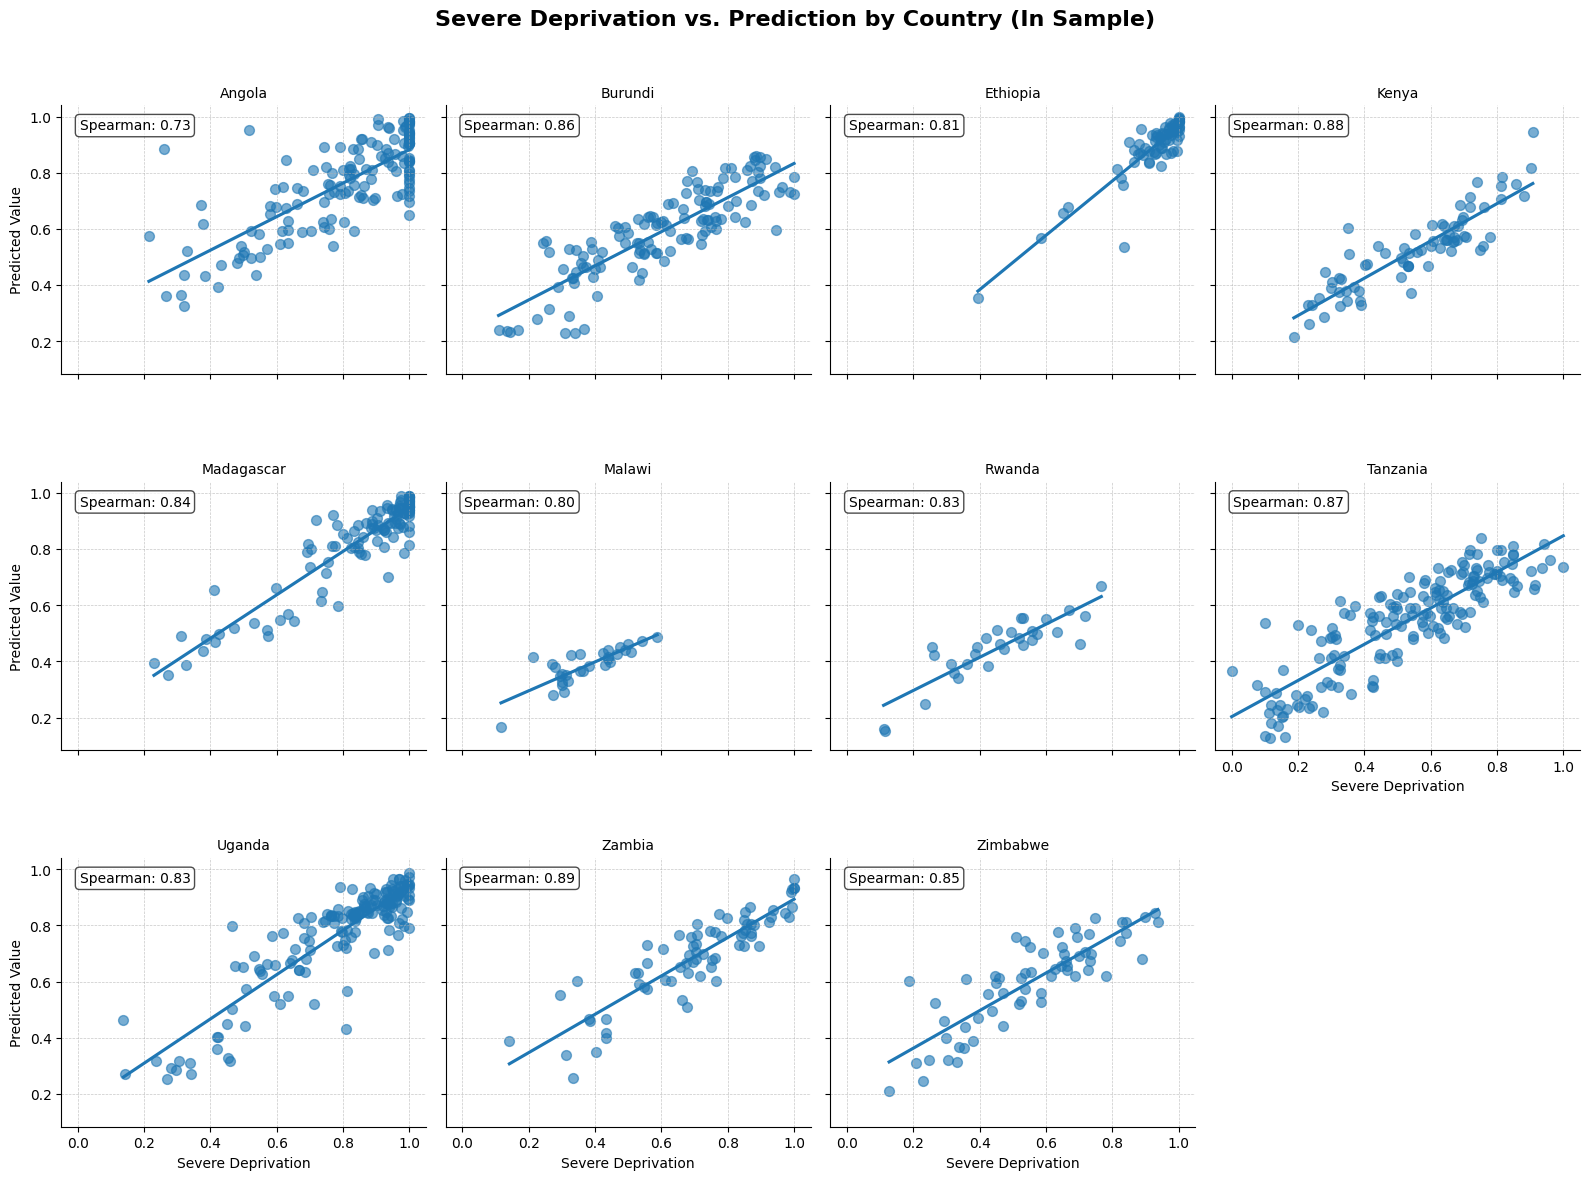

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# Create the facet grid scatter plots with regression lines
g = sns.lmplot(
    data=grouped_df,
    x='deprived_sev', 
    y='y_pred', 
    col='COUNTRY', 
    col_wrap=4, 
    height=4, 
    aspect=1, 
    scatter_kws={'alpha': 0.6, 's': 50},  # Increase marker size for better visibility
    ci=None,
    palette="Set2"  # Use a visually appealing palette
)
g.set_titles("{col_name}")  # This sets the title template to just the column name (country)
# Compute and annotate Spearman R for each subplot
for ax, country in zip(g.axes.flat, grouped_df['COUNTRY'].unique()):
    country_data = grouped_df[grouped_df['COUNTRY'] == country]
    rho, p_value = spearmanr(country_data['deprived_sev'], country_data['y_pred'])
    ax.text(
        0.05, 0.95, 
        f'Spearman: {rho:.2f}', 
        transform=ax.transAxes, 
        fontsize=10, 
        verticalalignment='top',
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.7)  # Add a background box for clarity
    )

# Improve layout and add a global title
plt.subplots_adjust(top=0.9, hspace=0.4)  # Adjust subplot spacing
g.fig.suptitle("Severe Deprivation vs. Prediction by Country (In Sample)", fontsize=16, fontweight='bold')

# Customize axis labels
g.set_axis_labels("Severe Deprivation", "Predicted Value")

# Add grid lines for clarity
for ax in g.axes.flat:
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

plt.show()

In [33]:
points_gdf = gpd.GeoDataFrame(
    grouped_df,
    geometry=gpd.points_from_xy(grouped_df['LONGNUM'], grouped_df['LATNUM']),
    crs="EPSG:4326"
)
admin2_gdf  = gpd.read_file('afr_adm2/afr_g2014_2013_2.shp')
# 3. Spatial join to find which admin 2 each point belongs to
joined_gdf = gpd.sjoin(points_gdf, admin2_gdf, how="left", predicate="within")

# Assume admin 2 name column in the shapefile is 'ADM2_NAME'
# Now joined_gdf contains 'ADM2_NAME' for each point along with 'value'.

# 4. Aggregate values by admin 2 region if multiple points belong to the same region
joined_gdf['ADM2_NAME'] = joined_gdf['ADM2_NAME_left']

# Merge aggregated data back into the admin2_gdf
choropleth_gdf = admin2_gdf.merge(joined_gdf, on='ADM2_CODE', how='right')
# choropleth_gdf = joined_gdf


In [34]:
# remove nan from choropleth_gdf
choropleth_gdf = choropleth_gdf.dropna(subset=['are'])
# remove inf from choropleth_gdf
choropleth_gdf = choropleth_gdf[~choropleth_gdf['are'].isin([float('inf')])]

<Axes: >

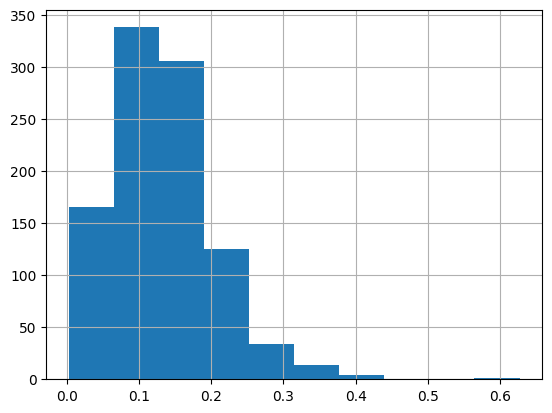

In [35]:
choropleth_gdf.error.hist()

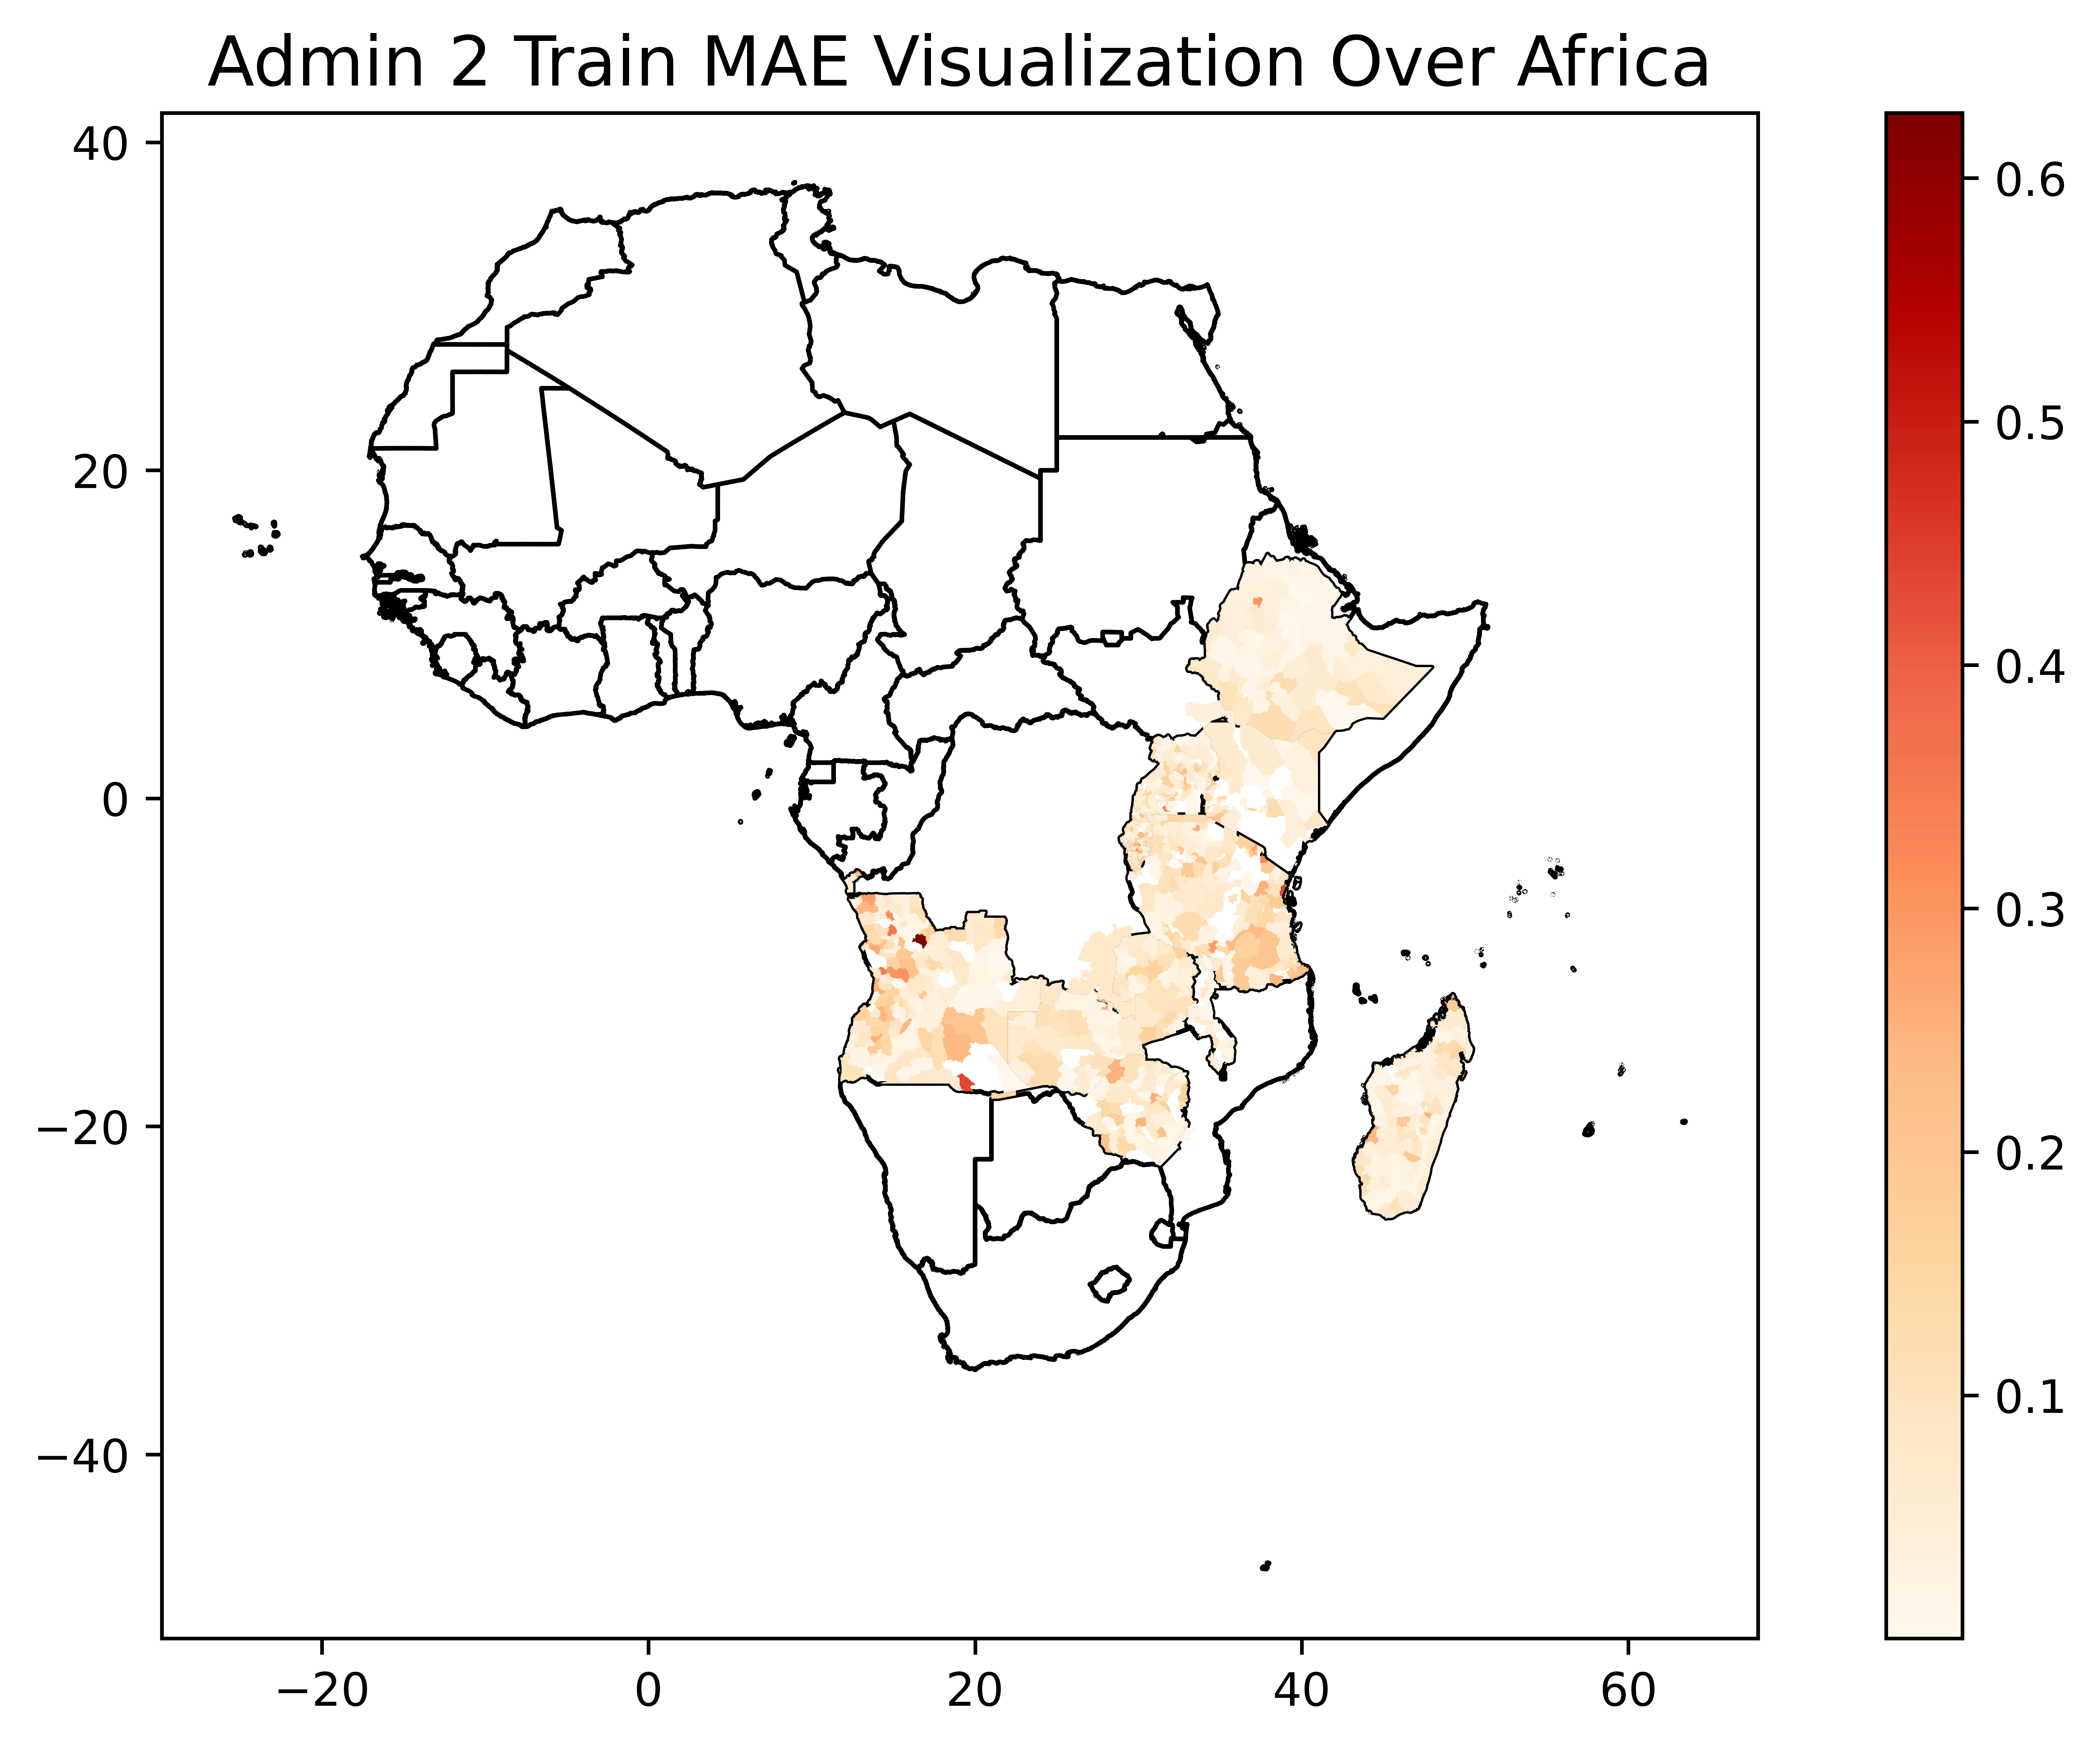

In [36]:
choropleth_gdf = gpd.GeoDataFrame(choropleth_gdf, geometry='geometry_x')


# Optionally set a title
import geopandas as gpd
import matplotlib.pyplot as plt

# Load Africa boundary shapefile (this could be a countries-level shapefile)
africa_gdf = gpd.read_file('afr_adm0/afr_g2014_2013_0.shp')

# Ensure all GeoDataFrames are in the same CRS
if africa_gdf.crs != choropleth_gdf.crs:
    africa_gdf = africa_gdf.to_crs(choropleth_gdf.crs)

fig, ax = plt.subplots(figsize=(10, 6), dpi=1000)

# Plot the Africa boundary as a base layer
africa_gdf.plot(ax=ax, color='white', edgecolor='black')

# Plot the admin 2 level choropleth on top # adjust line width
choropleth_gdf.plot(column='admin2_error', cmap='OrRd', legend=True, ax=ax, linewidth=0.5)

ax.set_title("Admin 2 Train MAE Visualization Over Africa", fontsize=15)
plt.show()

In [37]:
choropleth_gdf.REGION_x.unique()

array(['Middle Africa', 'Southern Africa', 'Eastern Africa', None, nan],
      dtype=object)

: 